In [1]:
# importando bibliotecas necessárias
import pandas as pd
import numpy as np


from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

# graphs
import matplotlib.pyplot as plt
import seaborn as sns


## Pré-Processamento

### Importando dados

In [2]:
dataframe_train = pd.read_csv('data/all_thyroid.csv')
dataframe_test = pd.read_csv('data/all_thyroid_test.csv')

### Limpeza do Dataframe

In [20]:
# função de limpeza do dataframe

def clean_dataframe(dataframe: pd.DataFrame, set: bool) -> pd.DataFrame:
  '''
  Função para limpar o dataframe, removendo colunas que não são necessárias
  '''

  #imports
  from sklearn.preprocessing import OrdinalEncoder

  #clones the dataframe
  dataframe_cp = dataframe.copy()

  dataframe_cp.drop(['TBG'],axis=1, inplace=True)

  #concatenando os targets e convergindo targets alterados para "positivo"
 
  pos_tiroid = dataframe_cp.query('target_hypo != "negative" | target_hyper != "negative"').index
  dataframe_cp['tiroid'] = 0
  dataframe_cp.loc[pos_tiroid, 'tiroid'] = 1
  dataframe_cp.tiroid.value_counts()

  dataframe_cp.drop(dataframe_cp.filter(like="measure").columns, axis=1, inplace=True)
  

  
  dataframe_cp = dataframe_cp[dataframe_cp.sex.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.T3.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.FTI.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.age.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.TT4.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.query_on_thyroxine.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.on_antithyroid_meds.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.sick.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.pregnant.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.I131_treatment.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.lithium.notnull()]
  dataframe_cp = dataframe_cp[dataframe_cp.hypopituitary.notnull()]
  dataframe_cp.TSH.fillna(3, inplace=True)
  dataframe_cp.T4U.fillna(dataframe_cp.T4U.median(), inplace=True)
  
  if set:
    dataframe_cp.drop(['patient_id', 'TT4', 'target_hyper', 'target_hypo', 'query_on_thyroxine', 'on_antithyroid_meds', 'sick', 'pregnant', 'I131_treatment', 'lithium', 'hypopituitary'], axis=1, inplace=True)
  
  #construindo o encoder para mudar os dados categóricos str para dados categóricos float
  encoder = OrdinalEncoder()
  categoricos = dataframe_cp.select_dtypes(include=[object])
  data_encoded = encoder.fit_transform(categoricos)
  colunas = categoricos.columns
  dataframe_cp[colunas] = encoder.fit_transform(categoricos)
  dataframe_cp.head()

  
  return dataframe_cp

In [21]:
df_train_clean_duarte = clean_dataframe(dataframe_train, set= True)

df_test_clean_duarte = clean_dataframe(dataframe_test, set=True)


df_train_clean = clean_dataframe(dataframe_train, set=False)

df_test_clean = clean_dataframe(dataframe_test, set=False)


In [23]:
df_train_clean_duarte.head()

,age,sex,on_thyroxine,thyroid_surgery,query_hypothyroid,query_hyperthyroid,goitre,tumor,psych,TSH,T3,T4U,FTI,referral_source,tiroid
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.30,2.5,1.14,109.0,1.0,0
4,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.72,1.2,0.87,70.0,3.0,0
7,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.20,0.6,0.70,115.0,3.0,0
8,66.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.60,2.2,0.93,132.0,3.0,0
9,68.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.40,1.6,0.89,93.0,3.0,0


In [6]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2799
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1993 non-null   float64
 1   sex                  1993 non-null   float64
 2   on_thyroxine         1993 non-null   float64
 3   query_on_thyroxine   1993 non-null   float64
 4   on_antithyroid_meds  1993 non-null   float64
 5   sick                 1993 non-null   float64
 6   pregnant             1993 non-null   float64
 7   thyroid_surgery      1993 non-null   float64
 8   I131_treatment       1993 non-null   float64
 9   query_hypothyroid    1993 non-null   float64
 10  query_hyperthyroid   1993 non-null   float64
 11  lithium              1993 non-null   float64
 12  goitre               1993 non-null   float64
 13  tumor                1993 non-null   float64
 14  hypopituitary        1993 non-null   float64
 15  psych                1993 non-null   f

### Utilizando o RFE para determinar as melhores variáveis com Árvore de Decisão

In [7]:
#separando dados para rfe
X = df_train_clean.drop(['tiroid', 'target_hyper', 'target_hypo', 'referral_source', 'patient_id'], axis=1)
y = df_train_clean['tiroid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#construindo e utilizando rfe
selector = RFE(DecisionTreeClassifier(random_state=42), step=1, verbose=0, importance_getter='auto')
selector = selector.fit(X_train, y_train)
#selector.get_feature_names_out()

#features ranked
features = selector.get_feature_names_out()
data_rank = pd.DataFrame(selector.ranking_, index=X.columns, columns=['rank'])

data_rank.sort_values(by='rank', ascending=True, inplace=True)
data_rank


,rank
age,1
TT4,1
T3,1
TSH,1
T4U,1
thyroid_surgery,1
FTI,1
sick,1
query_on_thyroxine,1
on_thyroxine,1


In [17]:
df_train_clean_rfe = df_train_clean.drop(['pregnant', 'psych', 'tumor', 'hypopituitary', 'I131_treatment', 'sex', 'goitre', 'query_hypothyroid', 'lithium', 'on_antithyroid_meds', 'query_hyperthyroid','tiroid', 'target_hyper', 'target_hypo', 'referral_source', 'patient_id'], axis=1)
df_test_clean_rfe = df_test_clean.drop(['pregnant', 'psych', 'tumor', 'hypopituitary', 'I131_treatment', 'sex', 'goitre', 'query_hypothyroid', 'lithium', 'on_antithyroid_meds', 'query_hyperthyroid','tiroid', 'target_hyper', 'target_hypo', 'referral_source', 'patient_id'], axis=1)

<AxesSubplot:>

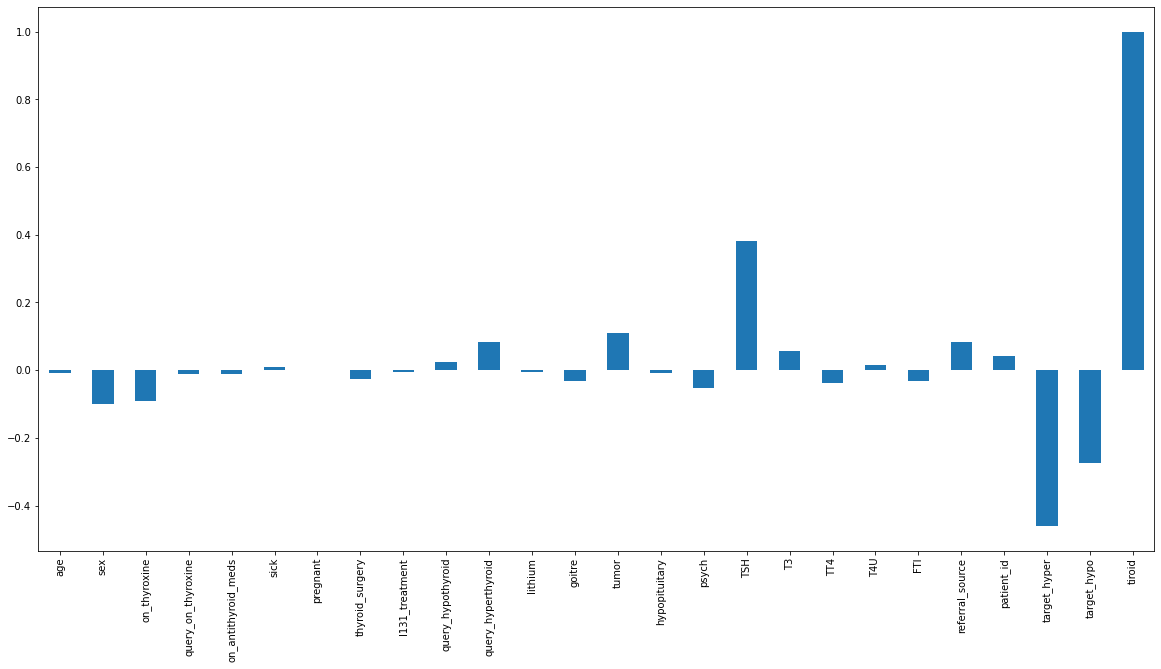

In [8]:
df_train_clean.corrwith(df_train_clean['tiroid']).plot.bar(figsize=(20,10))

In [9]:
df_train_clean.corrwith(df_train_clean['tiroid'])

age                   -0.006953
sex                   -0.099164
on_thyroxine          -0.090608
query_on_thyroxine    -0.012277
on_antithyroid_meds   -0.012277
sick                   0.008214
pregnant               0.001664
thyroid_surgery       -0.025316
I131_treatment        -0.006782
query_hypothyroid      0.024500
query_hyperthyroid     0.082025
lithium               -0.004630
goitre                -0.032673
tumor                  0.109505
hypopituitary         -0.007892
psych                 -0.053622
TSH                    0.382234
T3                     0.058042
TT4                   -0.038197
T4U                    0.014535
FTI                   -0.031746
referral_source        0.082404
patient_id             0.043351
target_hyper          -0.459768
target_hypo           -0.272721
tiroid                 1.000000
dtype: float64

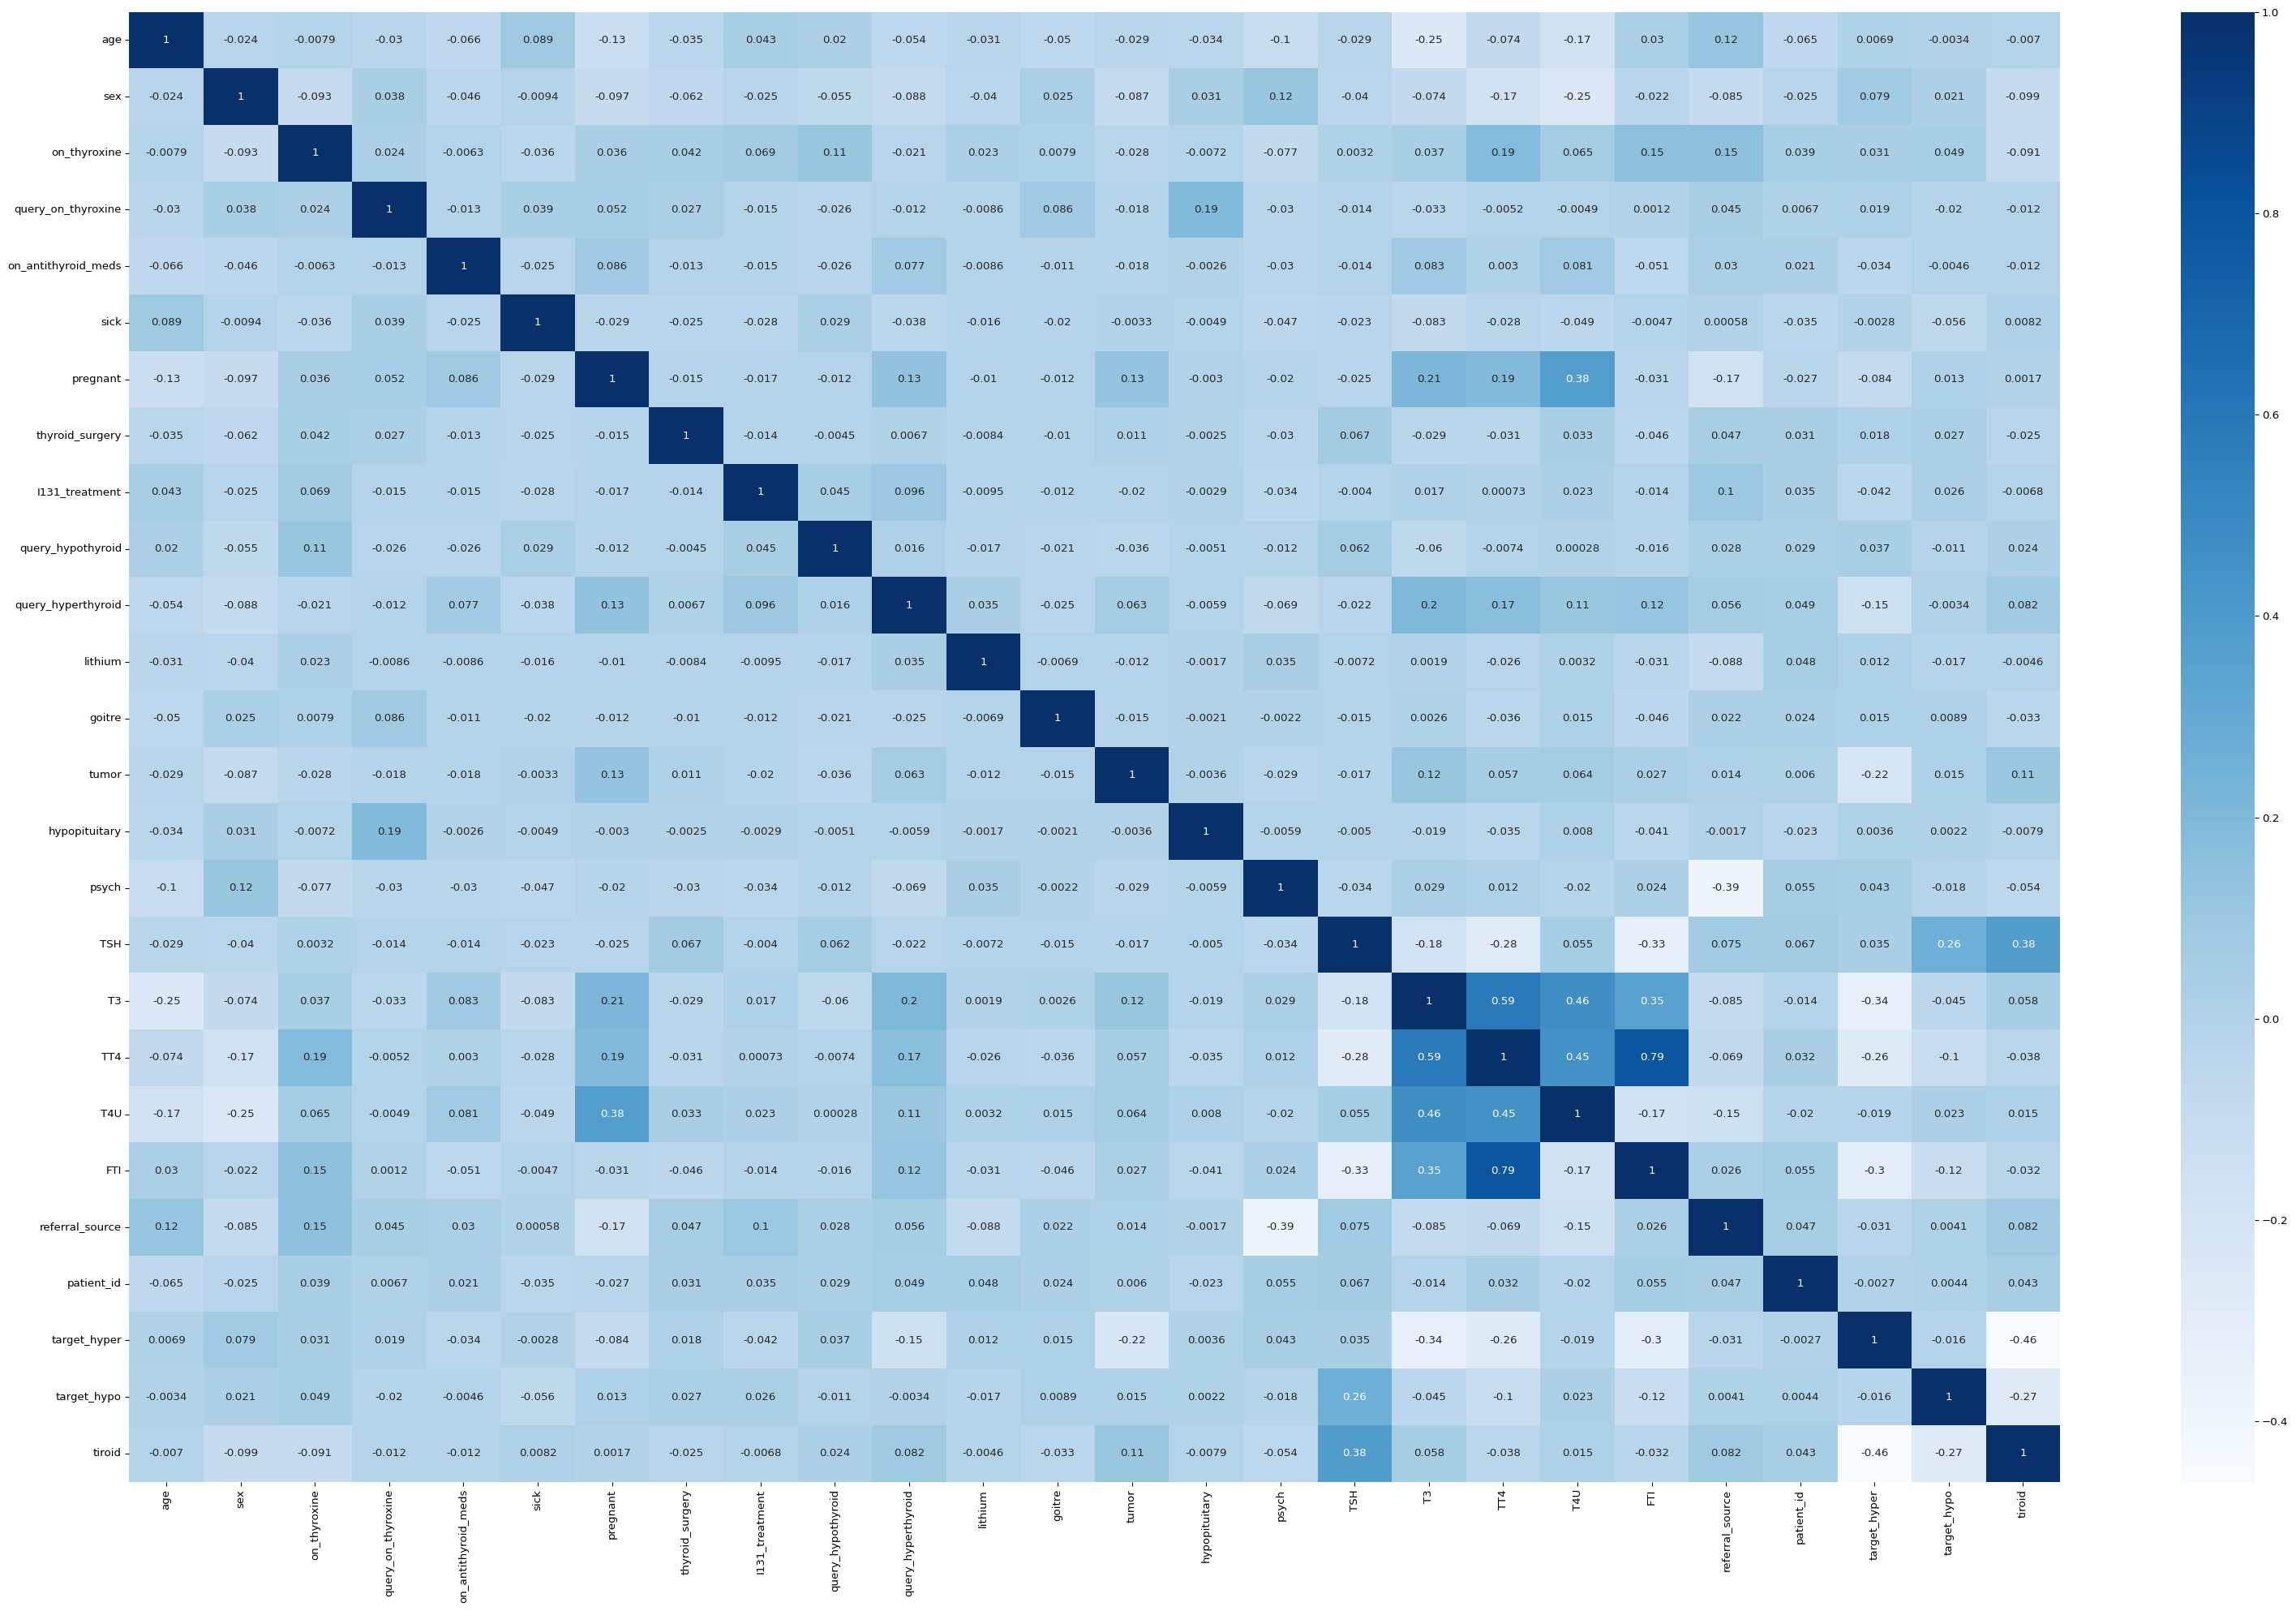

In [10]:
plt.figure( figsize=( 40,25 ), dpi=96 )
sns.heatmap( df_train_clean.corr(), cmap='Blues', annot=True )
plt.show()

--------